In [1]:
import h5py
import numpy as np
import h5flow
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import glob, os 

# Count number of hits per event
from collections import Counter

plt.style.use('../utils/dune.mplstyle')
import matplotlib.cm as cm
import matplotlib.colors as mcolors


In [2]:
def thd_correct(array):
    """
    Can go to a different file
    Baseline corrects waveforms
    """

    # Define start and end indices
    indices = np.arange(0, 41) * 25  # (39,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (39,)

    segment_range = np.arange(25)  # Shape: (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (39, 25)

    # Extract data using advanced indexing
    sliced_data = array[..., index_array]
    
    ranges = np.ptp(sliced_data, axis=-1)  # Compute range (n, 8, 64, 39)
    means = np.mean(sliced_data, axis=-1)  # Compute mean (n, 8, 64, 39)

    # Find ordering based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (n, 8, 64, 39)

    # Sort means using the ordering
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (n, 8, 64, 39)
    sorted_range = np.take_along_axis(ranges, smallest_ordering, axis=-1)
    # Compute average of 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:4], axis=-1)  # Shape (n, 8, 64)
    expanded_mean = average_mean[..., None] 
    broadcasted_mean = np.tile(expanded_mean, (1, 1000))  
    filtered_wvfm = array - broadcasted_mean

    return filtered_wvfm


In [3]:
# Single file test

path = '/pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_1758947778_0_TIME_MOD.FLOW.hdf5'
file = h5flow.data.H5FlowDataManager(path, "r")
print(f"Number of captures in this file {len(np.unique(file['mc_truth/trajectories/data']['event_id']))}")

Number of captures in this file 200


In [4]:
a= file["light/wvfm/data"]['samples']
a =  thd_correct(a)
# find an event with a signal: let's look at the waveform with the highest value in the last axis
event, adc, chan, tick = np.unravel_index(np.argmax(a, axis=None), a.shape)

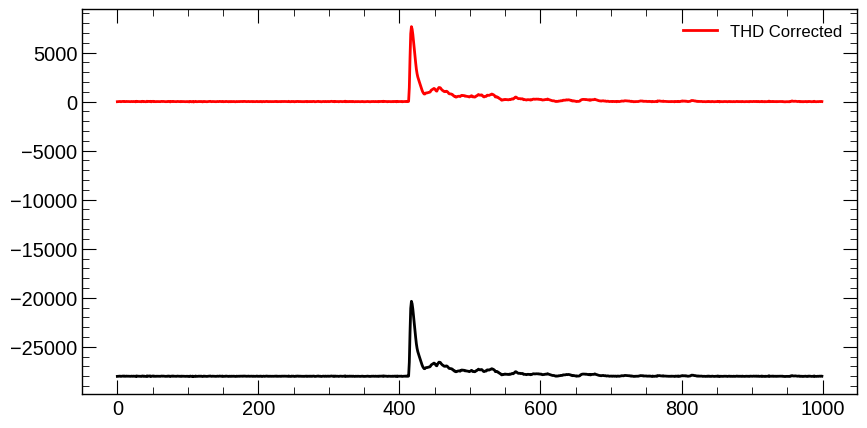

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(file['light/wvfm/data'][event]['samples'][adc,chan], alpha=1)
ax.plot(a[event, adc, chan], color='red', label='THD Corrected')
plt.legend()
plt.show()

In [6]:
def find_above_threshold(threshold,file):
    # now find how many waveforms there are that go above threshold
    #print(f"Selected threshold {threshold} ADC")
    n = 0
    summary = {}
    light = thd_correct(file['light/wvfm/data']['samples'])
    for i in range(len(file['light/wvfm/data'])):
        if np.max(light[i]) > threshold:
            n += 1
            # count how many channels are above threshold
            l = 0
            for j in range(8):
                for k in range(64):
                    if np.max(light[i][j,k]) > threshold:
                        l += 1
            #print(l, 'channels are above', threshold, 'in event', i)
            summary[i] = l
    #print(n, 'out of', len(file['light/wvfm/data']), 'events have at least one waveform that goes above', threshold)
    return n, len(file['light/wvfm/data'])

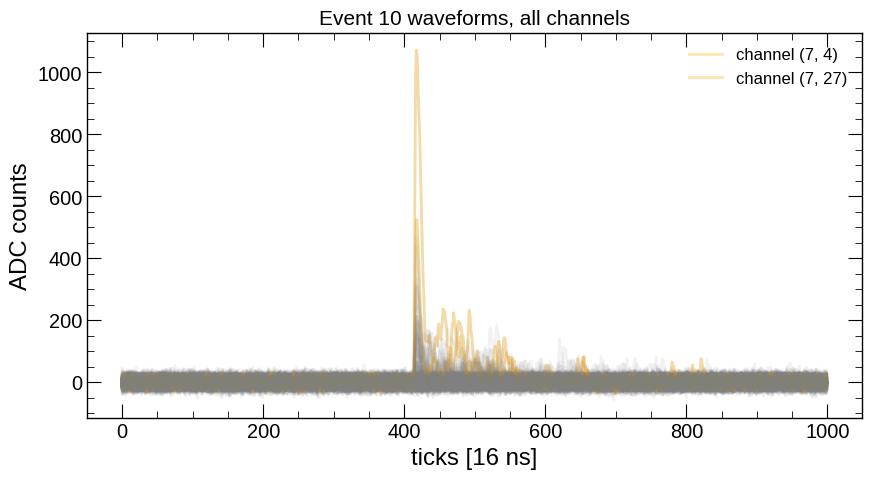

In [7]:
# for one event plot all waveforms
colors = ['r', 'b', 'c', 'm', 'y', 'g', 'k', 'orange']
event = 10
light = thd_correct(file['light/wvfm/data']['samples'])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(8):
    for j in range(64):
        ax.plot(light[event][i,j], c='grey', alpha=0.1)
        if np.max(light[event][i,j]) > 500:
            ax.plot(light[event][i,j], c=colors[i], alpha=0.3, label=f'channel {(i,j)}')
plt.xlabel('ticks [16 ns]')
plt.ylabel('ADC counts')
plt.legend()
plt.title('Event ' + str(event) + ' waveforms, all channels',fontsize=15)
plt.show()


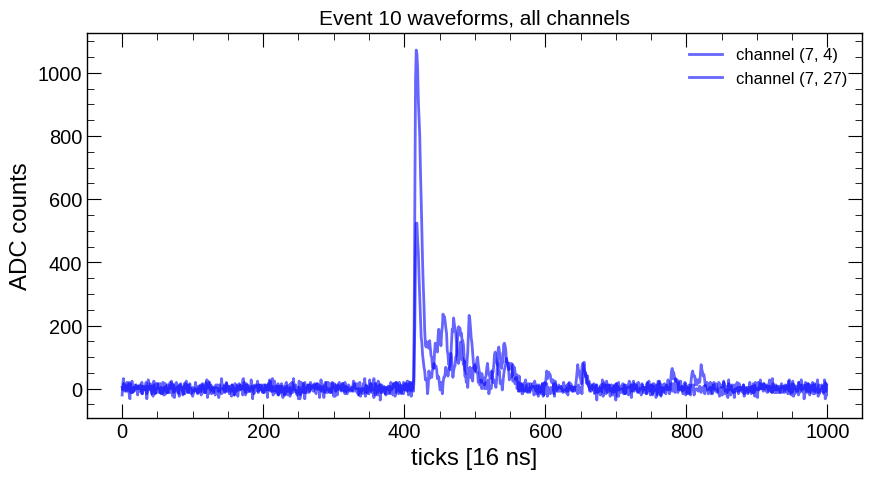

In [8]:
# for one event plot all waveforms
event = 10
light = thd_correct(file['light/wvfm/data']['samples'])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(8):
    for j in range(64):
        #ax.plot(light[event][i,j], c='grey', alpha=0.1)
        if np.max(light[event][i,j]) > 500:
            ax.plot(light[event][i,j], c='blue', alpha=0.6, label=f'channel {(i,j)}')
plt.xlabel('ticks [16 ns]')
plt.ylabel('ADC counts')
plt.legend()
plt.title('Event ' + str(event) + ' waveforms, all channels',fontsize=15)
plt.show()

/tmp/ipykernel_1289020/3885542016.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("turbo", n_channels)  # choose a gradient colormap


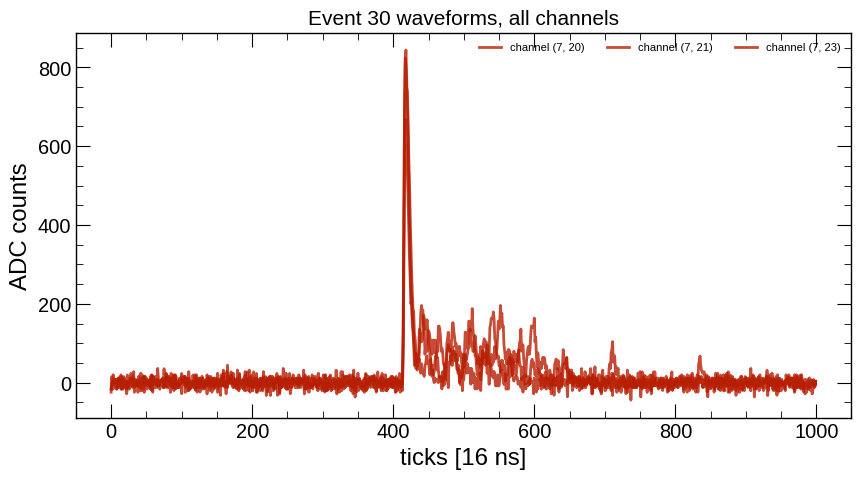

In [15]:
# for one event plot all waveforms
event = 30
light = thd_correct(file['light/wvfm/data']['samples'])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

n_channels = 8 * 64  # total number of channels
cmap = cm.get_cmap("turbo", n_channels)  # choose a gradient colormap
norm = mcolors.Normalize(vmin=0, vmax=n_channels - 1)

ch_id = 0
for i in range(8):
    for j in range(64):
        if np.max(light[event][i, j]) > 500:
            color = cmap(norm(ch_id))   # assign gradient color
            ax.plot(light[event][i, j], c=color, alpha=0.8, label=f'channel {(i,j)}')
        ch_id += 1

plt.xlabel('ticks [16 ns]')
plt.ylabel('ADC counts')
plt.title(f'Event {event} waveforms, all channels', fontsize=15)

# avoid duplicate legend entries by taking only the first occurrence
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=8, ncol=4)

plt.show()

In [10]:
path = '/pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/'

threshold_arr = np.linspace(100,2000,20)
eff_array = []


for thresh in threshold_arr:
    print(f"Selected threshold {thresh}")
    n_total = 0.
    n_passing = 0.
    for file_h5 in glob.glob(path + "*_TIME_MOD.FLOW.hdf5"):   
        file_h5 = h5flow.data.H5FlowDataManager(file_h5, "r") 
        n_passing_temp, n_total_temp = find_above_threshold(thresh, file_h5)
        n_total+=n_total_temp 
        n_passing+=n_passing_temp

    eff_array.append(n_passing/n_total) 
  

Selected threshold 100.0


Selected threshold 200.0


KeyboardInterrupt: 

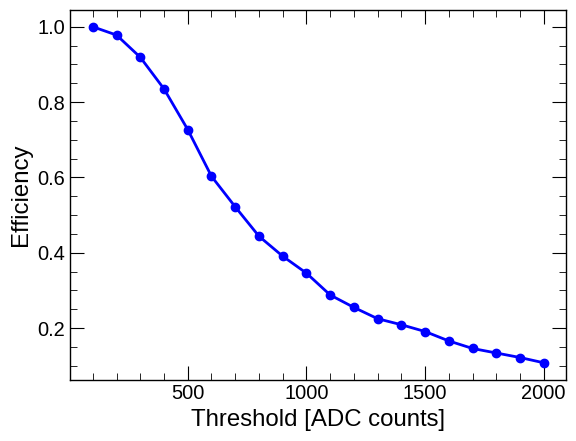

In [ ]:
plt.plot(threshold_arr,eff_array,marker='o',color='blue')
plt.ylabel('Efficiency')
plt.xlabel('Threshold [ADC counts]')
plt.show() 

In [ ]:
def coord_in_tpc(x, y, z):
    if y < (-46.53 + -15.51) or y > (56.87 + 5.17):
        return -1
    if z < 0 and z > -2*31.49:
        if x < -33.5 and x > -2*33.5:
            return 8
        if x < 0 and x > -33.5:
            return 7
        if x < 33.5 and x > 0:
            return 4
        if x < 2*33.5 and x > 33.5:
            return 3
    elif z > 0 and z < 2*31.49:
        if x < -33.5 and x > -2*33.5:
            return 6
        if x < 0 and x > -33.5:
            return 5
        if x < 33.5 and x > 0:
            return 2
        if x < 2*33.5 and x > 33.5:
            return 1
    return -1  # catch all other cases (like z == 0)

In [ ]:
path = '/pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/'
filename = '2x2_MyQGSP_BERT_ArHP_AmBe_1758947778_{num}_TIME_MOD.FLOW.hdf5'

threshold = 1000
min_hits_required = 1
z_locations = np.array([-60, -1, 1, 60])  # known LCM z positions

z_distances = []
triggered = []

z_distances_per_tpc = {i: [] for i in range(1, 9)}
triggered_per_tpc = {i: [] for i in range(1, 9)}

for file_h5 in glob.glob(path + "*_TIME_MOD.FLOW.hdf5"):
    print(f'File {file_h5}')
    try:
        file = h5flow.data.H5FlowDataManager(file_h5, "r")

        # Get all hits' event IDs
        hit_event_ids = file['charge/calib_final_hits/data']['id'][:]
        hit_counts = Counter(hit_event_ids)  # maps event_id -> hit count
        traj = file['mc_truth/trajectories/data']
        pdg_id = traj['pdg_id'][:]
        start_proc = traj['start_process'][:]
        start_subproc = traj['start_subprocess'][:]
        start_z = traj['xyz_start'][:]
        event_ids = traj['event_id'][:]

        # Find indices of captured neutrons
        is_Ar41 = pdg_id == 1000180410
        is_capture = (start_proc == 4) & (start_subproc == 131)
        is_valid = is_Ar41 & is_capture  

        capture_z_per_event = {}
        for evt, z in zip(event_ids[is_valid], start_z[is_valid]):
            if evt not in capture_z_per_event:
                capture_z_per_event[evt] = z  # use first found if multiple
        print(f"{len(capture_z_per_event)} capture events found in file {file_h5}")
        # z_verts = file['mc_truth/interactions/data']['z_vert'][:]
        # z_verts = file['charge/calib_final_hits/data']['z'][:]

        data = thd_correct(file['light/wvfm/data']['samples'])

        for evt in range(len(data)):
            # try:
            if hit_counts[evt] < min_hits_required:
                continue  # skip this event if not enough hits
            if np.unique(event_ids)[evt] not in event_ids[is_valid]:
                continue  # skip if no capture
            coord = capture_z_per_event[np.unique(event_ids)[evt]]
            x, y, z = coord
            z_vert = z
            tpc = coord_in_tpc(x, y, z)
            if tpc == -1:
                continue

            nearest_z = z_locations[np.argmin(np.abs(z_locations - z))]
            dz = abs(z - nearest_z)

            wvfm = data[evt]
            event_triggered = np.any(wvfm > threshold)

            z_distances_per_tpc[tpc].append(dz)
            triggered_per_tpc[tpc].append(event_triggered)

            z_distances.append(dz)
            triggered.append(event_triggered)

                # except Exception as e:
                #     print("error:", e)
                    # continue


    except Exception as e:
        print(f'Error in file {file_h5}: {e}')
        continue

# Convert to arrays
z_distances = np.array(z_distances)
triggered = np.array(triggered)

# Bin efficiency vs. z-distance
bins = np.linspace(0, 30, 30)  # 2 cm bins up to 30 cm
bin_centers = 0.5 * (bins[:-1] + bins[1:])
efficiencies = []
num = []
denom = []
errors = []

for i in range(len(bins) - 1):
    in_bin = (z_distances >= bins[i]) & (z_distances < bins[i + 1])
    n_total = np.sum(in_bin)
    n_triggered = np.sum(triggered[in_bin])

    if n_total > 0:
        eff = n_triggered / n_total
        err = np.sqrt(eff * (1 - eff) / n_total)
    else:
        eff = 0
        err = 0

    efficiencies.append(eff)
    errors.append(err)
    num.append(n_triggered)
    denom.append(n_total)


File /pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_1758947778_0_TIME_MOD.FLOW.hdf5


200 capture events found in file /pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_1758947778_0_TIME_MOD.FLOW.hdf5
File /pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_1758947779_1_TIME_MOD.FLOW.hdf5
200 capture events found in file /pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_1758947779_1_TIME_MOD.FLOW.hdf5
File /pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_1758947957_2_TIME_MOD.FLOW.hdf5
200 capture events found in file /pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_1758947957_2_TIME_MOD.FLOW.hdf5
File /pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_1758947958_3_TIME_MOD.FLOW.hdf5
200 capture events found in file /pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_1758947958_3_TIME_MOD.FLOW.hdf5
File /pscratch/sd/l/lmlepin/grid_o

In [ ]:
def eff_vs_z(string_path, threshold):

    min_hits_required = 1
    z_locations = np.array([-60, -1, 1, 60])  # known LCM z positions

    z_distances = []
    triggered = []

    z_distances_per_tpc = {i: [] for i in range(1, 9)}
    triggered_per_tpc = {i: [] for i in range(1, 9)}

    for file_h5 in glob.glob(string_path):
        print(f'File {file_h5}')
        try:
            file = h5flow.data.H5FlowDataManager(file_h5, "r")

            # Get all hits' event IDs
            hit_event_ids = file['charge/calib_final_hits/data']['id'][:]
            hit_counts = Counter(hit_event_ids)  # maps event_id -> hit count
            traj = file['mc_truth/trajectories/data']
            pdg_id = traj['pdg_id'][:]
            start_proc = traj['start_process'][:]
            start_subproc = traj['start_subprocess'][:]
            start_z = traj['xyz_start'][:]
            event_ids = traj['event_id'][:]

            # Find indices of captured neutrons
            is_Ar41 = pdg_id == 1000180410
            is_capture = (start_proc == 4) & (start_subproc == 131)
            is_valid = is_Ar41 & is_capture  

            capture_z_per_event = {}
            for evt, z in zip(event_ids[is_valid], start_z[is_valid]):
                if evt not in capture_z_per_event:
                    capture_z_per_event[evt] = z  # use first found if multiple
            print(f"{len(capture_z_per_event)} capture events found in file {file_h5}")
            # z_verts = file['mc_truth/interactions/data']['z_vert'][:]
            # z_verts = file['charge/calib_final_hits/data']['z'][:]

            data = thd_correct(file['light/wvfm/data']['samples'])

            for evt in range(len(data)):
                # try:
                if hit_counts[evt] < min_hits_required:
                    continue  # skip this event if not enough hits
                if np.unique(event_ids)[evt] not in event_ids[is_valid]:
                    continue  # skip if no capture
                coord = capture_z_per_event[np.unique(event_ids)[evt]]
                x, y, z = coord
                z_vert = z
                tpc = coord_in_tpc(x, y, z)
                if tpc == -1:
                    continue

                nearest_z = z_locations[np.argmin(np.abs(z_locations - z))]
                dz = abs(z - nearest_z)

                wvfm = data[evt]
                event_triggered = np.any(wvfm > threshold)

                z_distances_per_tpc[tpc].append(dz)
                triggered_per_tpc[tpc].append(event_triggered)

                z_distances.append(dz)
                triggered.append(event_triggered)

                    # except Exception as e:
                    #     print("error:", e)
                        # continue


        except Exception as e:
            print(f'Error in file {file_h5}: {e}')
            continue

    # Convert to arrays
    z_distances = np.array(z_distances)
    triggered = np.array(triggered)

    # Bin efficiency vs. z-distance
    bins = np.linspace(0, 30, 30)  # 2 cm bins up to 30 cm
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    efficiencies = []
    num = []
    denom = []
    errors = []

    for i in range(len(bins) - 1):
        in_bin = (z_distances >= bins[i]) & (z_distances < bins[i + 1])
        n_total = np.sum(in_bin)
        n_triggered = np.sum(triggered[in_bin])

        if n_total > 0:
            eff = n_triggered / n_total
            err = np.sqrt(eff * (1 - eff) / n_total)
        else:
            eff = 0
            err = 0

        efficiencies.append(eff)
        errors.append(err)
        num.append(n_triggered)
        denom.append(n_total)

    # Assuming these arrays are already defined:
    # bin_centers, efficiencies, errors

    mean_eff = np.mean(efficiencies)

    plt.errorbar(
        bin_centers,
        efficiencies,
        yerr=errors,
        fmt='o',
        label=f'Efficiency (mean = {mean_eff:.2f})',
        capsize=3,
        color='blue'
    )
    plt.xlabel("Distance to nearest light trap [cm]")
    plt.ylabel(f"Trigger efficiency (> {threshold} ADC counts)")
    plt.title("Light self-trigger efficiency vs. z-distance", fontsize=20)
    plt.legend()
    plt.savefig(f"efficiency_vs_z_threshold_{threshold}.png",bbox_inches="tight")


In [ ]:

path = '/pscratch/sd/l/lmlepin/grid_output/AmBe_in_mod0_debug/FLOW/'
filename = '2x2_MyQGSP_BERT_ArHP_AmBe_1758947778_{num}_TIME_MOD.FLOW.hdf5'
string_path = path + "*_TIME_MOD.FLOW.hdf5"

eff_vs_z(string_path,200)
eff_vs_z(string_path,500)
eff_vs_z(string_path,800)
eff_vs_z(string_path,1000)